# How to predict whether a sentence is ironical or not ?

Irony is very present in our daily conversations. It is defined as a way of mocking (someone or something) by saying the opposite of what one means. It often happens that we say something we don't actually think, usually to make others laugh, and humans understand each other quite well in these situations. However, it is very difficult to computationally predict whether a sentence expresses irony, as highlighted in this article by Samuel Laperle «Enjeux liés à la détection de l’ironie »  available here: https://hal.science/hal-03265905/document. We will attempt to take on the challenge in our study by creating a prediction model to determine whether a sentence is ironic or not.
We will ask us how to predict if a sentence is ironical or not ?
We will use to answer this question a dataset find on metatext and called sentimental-liar. More informations here : https://metatext.io/datasets/sentimental-liar


**Objective** : Predict if a sentence is ironical



We will execute the features engineering part in a first dataset, and the modeling part in a second dataset.

## 1. Library import and fonction construction

### 1.1. Library import

In [1]:
!pip install tqdm

In [2]:
!python -m spacy download en_core_web_md

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.8/42.8 MB 14.6 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_md')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.linear_model import LogisticRegression, LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

from tqdm import tqdm

import matplotlib.pyplot as plt
from matplotlib import rcParams

from google.colab import files

import string

import spacy
import torch
from transformers import BertModel, BertTokenizer

### 1.2. Initialize models and tokenizer for Word embedding

In [4]:
nlp = spacy.load('en_core_web_md')  # Using spaCy model for word embeddings

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased') # Using BERT model for sentence embeddings
model = BertModel.from_pretrained('bert-base-uncased')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

## 2. Data import

In [5]:
import pandas as pd
import requests
import io
import numpy as np

# Lien direct Google Drive
url = "https://drive.google.com/uc?export=download&id=1XTyPYIR6V0-BMiXl71Y2hs0-sc2UX9_A"

# Téléchargement et traitement ligne par ligne
response = requests.get(url)
response.raise_for_status()  # Vérifie que le téléchargement est réussi

# Liste pour stocker les données
data = []

# Lecture ligne par ligne
lines = response.text.splitlines()
for line in lines:
    try:
        # Tentative de décomposer la ligne avec le séparateur '\t'
        parsed_line = line.split('\t')
        data.append(parsed_line)
    except Exception:
        # En cas d'erreur, ajoute une ligne avec des valeurs NaN
        data.append([np.nan] * len(parsed_line))

# Création du DataFrame en spécifiant les colonnes
df_text = pd.DataFrame(data)
df_text[['texts']] = df_text[[0]]
df_text = df_text[['texts']]
# Affichage du DataFrame
display(df_text)


,texts
0,seeing ppl walking w/ crutches makes me really...
1,"look for the girl with the broken smile, ask h..."
2,Now I remember why I buy books online @user #s...
3,@user @user So is he banded from wearing the c...
4,Just found out there are Etch A Sketch apps. ...
...,...
2857,I don't have to respect your beliefs.||I only ...
2858,Women getting hit on by married managers at @u...
2859,@user no but i followed you and i saw you post...
2860,@user I dont know what it is but I'm in love y...


In [6]:
# Lien direct pour télécharger le fichier
url = "https://drive.google.com/uc?export=download&id=13lRbHeG9BVrgW5J2LpvLSDcp5mW12Kws"

# Lecture du fichier avec des options supplémentaires pour éviter les erreurs
df_label = pd.read_csv(url, sep='\t', encoding='utf-8', header = None)  # Changez `sep` si nécessaire
df_label.columns = ['irony']
df_label

,irony
0,1
1,0
2,1
3,1
4,1
...,...
2857,0
2858,1
2859,0
2860,0


In [7]:
df = pd.concat([df_text, df_label], axis=1)
df

,texts,irony
0,seeing ppl walking w/ crutches makes me really...,1
1,"look for the girl with the broken smile, ask h...",0
2,Now I remember why I buy books online @user #s...,1
3,@user @user So is he banded from wearing the c...,1
4,Just found out there are Etch A Sketch apps. ...,1
...,...,...
2857,I don't have to respect your beliefs.||I only ...,0
2858,Women getting hit on by married managers at @u...,1
2859,@user no but i followed you and i saw you post...,0
2860,@user I dont know what it is but I'm in love y...,0


In [8]:
display(df_text)

,texts
0,seeing ppl walking w/ crutches makes me really...
1,"look for the girl with the broken smile, ask h..."
2,Now I remember why I buy books online @user #s...
3,@user @user So is he banded from wearing the c...
4,Just found out there are Etch A Sketch apps. ...
...,...
2857,I don't have to respect your beliefs.||I only ...
2858,Women getting hit on by married managers at @u...
2859,@user no but i followed you and i saw you post...
2860,@user I dont know what it is but I'm in love y...


## 3. Representation of predicted variable

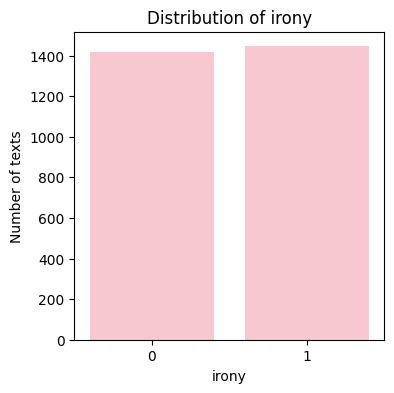

In [9]:
# Predicted variable
angerYes = df['irony'].value_counts()

# Plot the barplot
plt.figure(figsize=(4, 4))  # Adjusted figure size for better readability
sns.barplot(x=angerYes.index, y=angerYes.values, color='pink')

# Add labels and title
plt.xlabel('irony')
plt.ylabel('Number of texts')
plt.title('Distribution of irony')
plt.show()

## 4. Features engineering

### 4.1. Generic bag of most frequent words, without stopwords

In [10]:
# List of common English stopwords
stopwords = set([
    "a", "an", "the", "and", "or", "but", "if", "then", "so", "because", "as",
    "with", "on", "in", "at", "by", "for", "about", "against", "between",
    "to", "from", "up", "down", "out", "over", "under", "again", "further",
    "here", "there", "when", "where", "why", "how", "all", "any", "both",
    "each", "few", "more", "most", "other", "some", "such", "no", "nor",
    "not", "only", "own", "same", "so", "than", "too", "very"
])

# Function to remove punctuation and count all word occurrences, excluding stopwords
def count_all_words_no_stopwords(sentence):
    # Remove punctuation, convert to lowercase, and split into words
    sentence = sentence.translate(str.maketrans('', '', string.punctuation)).lower()
    sentence_words = sentence.split()  # Split the sentence into words
    filtered_words = [word for word in sentence_words if word not in stopwords] # Remove stopwords from the word list
    return {word: filtered_words.count(word) for word in set(filtered_words)}

In [11]:
# Step 1: Create a list of dictionaries for each sentence with word counts excluding stop words
word_counts = [count_all_words_no_stopwords(sentence) for sentence in df['texts']]

# Step 2: Create a DataFrame from the word counts and fill missing values with 0
df_word_count = pd.DataFrame(word_counts).fillna(0).astype(int)

# Step 3: Calculate the total occurrences of each word
word_totals = df_word_count.sum()

# Step 4: Filter to keep only words that have at least 100 occurrences
words_to_keep = word_totals[word_totals >= 100].index.tolist()

# Step 5: Keep only the columns corresponding to the words in 'words_to_keep'
df_bag_of_word = df_word_count[words_to_keep]

# Step 6: Ensure that the indices of df and df_bag_of_word are aligned
df_bag_of_word.index = df.index  # Align the index of df_bag_of_word with that of df

# Step 7: Concatenate the two DataFrames to add 'irony' to the bag of words
df_bag_of_word = pd.concat([df_bag_of_word, df[['irony']]], axis=1)

# Step 8: Drop rows with missing values
df_bag_of_word = df_bag_of_word.dropna()

# Display the resulting DataFrame
df_bag_of_word


,of,my,me,be,now,user,i,is,are,just,...,that,can,we,love,your,it,have,dont,was,irony
0,1,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,1,1,2,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,0,0,0,0,0,2,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1
4,0,0,0,0,0,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2857,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,2,0,3,1,0,0
2858,0,0,1,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2859,0,0,0,0,0,1,4,0,0,0,...,1,0,0,0,0,0,0,0,0,0
2860,0,0,0,0,0,1,1,1,0,0,...,0,0,0,2,1,1,0,1,0,0


### 4.2 World embeddings

In [12]:
tqdm.pandas()
def average_word_embedding(text):
    doc = nlp(text)
    word_embeddings = [token.vector for token in doc]
    if word_embeddings:
        return sum(word_embeddings) / len(word_embeddings)
    else:
        return [0] * 300  # spaCy uses 300-dimensional embeddings

df['Average Word Embedding'] = df['texts'].progress_apply(average_word_embedding)

100%|██████████| 2862/2862 [00:40<00:00, 70.05it/s]


In [13]:
# Expand the averaged word embeddings into separate columns
word_embedding_cols = pd.DataFrame(df['Average Word Embedding'].tolist(), index=df.index)
word_embedding_cols.columns = [f'Average_Word_Embedding_{i+1}' for i in range(300)]

In [14]:
# Concatenate the word embedding columns to the DataFrame
df_word_embedding = pd.concat([df['irony'], word_embedding_cols], axis=1)

In [15]:
df_word_embedding

,irony,Average_Word_Embedding_1,Average_Word_Embedding_2,Average_Word_Embedding_3,Average_Word_Embedding_4,Average_Word_Embedding_5,Average_Word_Embedding_6,Average_Word_Embedding_7,Average_Word_Embedding_8,Average_Word_Embedding_9,...,Average_Word_Embedding_291,Average_Word_Embedding_292,Average_Word_Embedding_293,Average_Word_Embedding_294,Average_Word_Embedding_295,Average_Word_Embedding_296,Average_Word_Embedding_297,Average_Word_Embedding_298,Average_Word_Embedding_299,Average_Word_Embedding_300
0,1,-0.623894,0.792558,-2.186175,-0.372055,2.715074,0.218922,0.548478,3.763309,-0.529591,...,1.121402,0.624327,0.812582,-1.058928,-0.564151,-0.710050,0.093346,-1.236202,-4.309378,-0.517057
1,0,-0.745687,2.073689,-2.795128,-1.255372,2.411135,1.052030,-0.599766,5.016446,-0.816626,...,0.515603,-1.008624,-0.157885,-0.292001,-0.921117,0.270116,-0.168507,0.775776,-4.838754,1.145793
2,1,-0.550137,0.240913,-1.754669,-2.128440,-3.764561,0.792897,1.153168,2.426471,-3.721498,...,2.808935,-0.556405,1.522478,-0.036224,-2.134692,-0.780140,1.800978,1.845947,-3.692695,0.440292
3,1,-0.644534,1.882416,-1.395405,-0.486086,1.039252,0.019061,0.300466,2.025311,0.285460,...,1.377846,-0.687466,1.781516,-0.768728,-0.686885,0.679941,1.123513,0.080642,-1.661254,1.377343
4,1,-0.392542,0.603784,-0.356930,0.773068,1.398230,0.680707,1.234802,1.486290,-1.161698,...,-0.129554,-0.950335,1.390735,-0.076897,-0.726016,0.682689,0.373667,-0.909967,-2.141481,0.254790
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2857,0,-0.415973,4.913784,-5.135102,-1.871229,-0.424539,1.782564,1.246084,3.612165,-4.101847,...,1.309386,-0.210777,-0.662552,-1.214972,-0.578932,-1.365409,-0.097708,0.674817,-5.745248,3.062205
2858,1,0.137787,-0.165283,-3.168905,1.315582,1.798445,-0.571614,0.245352,3.073169,-0.704461,...,1.287688,0.489932,-1.236288,0.234981,-2.990087,0.409326,1.342555,0.031471,-0.852824,1.613507
2859,0,0.021936,0.283038,-2.721251,-2.744000,-2.127574,-0.491878,-0.126956,3.684839,-4.155490,...,2.795556,-0.220150,4.444219,-2.590191,-2.155998,2.093228,2.217273,0.187461,-5.151009,0.374190
2860,0,1.526422,1.699203,-2.998710,-2.574385,-1.887390,0.555843,1.684765,2.693125,-2.625650,...,2.356534,0.582310,1.587730,-2.323588,-1.375875,-0.976204,2.614103,1.164941,-3.996766,2.418257


### 4.3 Sentence embedding

In [16]:
tqdm.pandas()
def get_sentence_embedding(text):
    inputs = tokenizer(text, return_tensors='pt', truncation=True, padding=True, max_length=512)
    outputs = model(**inputs)
    # Use the CLS token representation as the sentence embedding
    sentence_embedding = outputs.last_hidden_state[:, 0, :].detach().numpy()
    return sentence_embedding.flatten()

df['Sentence Embedding'] = df['texts'].progress_apply(get_sentence_embedding)

100%|██████████| 2862/2862 [07:45<00:00,  6.15it/s]


In [17]:
# Expand the sentence embeddings into separate columns (using pd.concat for performance)
sentence_embedding_size = model.config.hidden_size  # BERT hidden size (usually 768)
sentence_embedding_cols = pd.DataFrame(df['Sentence Embedding'].tolist(), index=df.index)
sentence_embedding_cols.columns = [f'Sentence_Embedding_{i+1}' for i in range(sentence_embedding_size)]

In [18]:
# Concatenate the sentence embedding columns to the DataFrame
df = pd.concat([df, sentence_embedding_cols], axis=1)

# Keep only the sentence embedding columns and 'irony'
columns_to_keep = list(sentence_embedding_cols.columns) + ['irony']
df_sentence_embedding = df[columns_to_keep]

df_sentence_embedding

,Sentence_Embedding_1,Sentence_Embedding_2,Sentence_Embedding_3,Sentence_Embedding_4,Sentence_Embedding_5,Sentence_Embedding_6,Sentence_Embedding_7,Sentence_Embedding_8,Sentence_Embedding_9,Sentence_Embedding_10,...,Sentence_Embedding_760,Sentence_Embedding_761,Sentence_Embedding_762,Sentence_Embedding_763,Sentence_Embedding_764,Sentence_Embedding_765,Sentence_Embedding_766,Sentence_Embedding_767,Sentence_Embedding_768,irony
0,0.037271,0.288889,0.382283,-0.006436,-0.418397,-0.603479,0.443474,0.633591,-0.178565,-0.661667,...,-0.073888,0.377625,-0.130956,0.424157,-0.026347,-0.017935,-0.366581,0.345594,0.124437,1
1,-0.239384,0.115341,-0.056706,-0.400722,-0.328102,-0.043605,0.305259,0.479864,-0.070552,-0.475837,...,-0.401149,-0.000700,0.228261,-0.223528,0.565738,-0.348445,0.080054,0.025412,0.596070,0
2,0.143000,0.142331,0.122259,-0.078430,-0.067211,-0.247910,0.250157,0.437332,-0.227183,-0.372910,...,-0.433088,-0.205428,0.007005,0.345982,-0.182748,-0.122095,-0.134963,0.170838,0.280598,1
3,0.291536,-0.003828,-0.087659,-0.000985,-0.247611,-0.116834,0.391652,0.179078,-0.028538,-0.361505,...,0.103418,0.118967,-0.202276,-0.199983,-0.122162,-0.054098,-0.325675,0.460774,0.446290,1
4,-0.045775,-0.062084,0.038487,0.225337,-0.401410,-0.564525,0.561134,0.719394,-0.034191,-0.372070,...,-0.058138,-0.078144,-0.199974,0.474694,-0.164658,-0.563821,-0.432837,0.313833,0.658722,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2857,0.240482,0.407762,-0.216748,-0.306831,-0.660285,-0.570560,0.823977,0.821655,0.130606,-0.176757,...,0.271232,0.037490,-0.303465,0.305116,-0.015278,0.243161,-0.609509,0.468792,0.921516,0
2858,0.169674,0.410665,-0.131282,-0.035778,-0.483309,-0.240251,0.614343,0.504015,0.005528,-0.061173,...,-0.372678,-0.056112,-0.252996,0.319624,0.017259,-0.306690,-0.599260,0.071827,0.358606,1
2859,0.034766,0.263894,0.113522,-0.321205,-0.229827,-0.644035,0.614931,0.753473,0.141837,-0.376109,...,-0.303587,0.098658,-0.212647,0.201183,-0.133057,-0.357476,-0.164758,0.416585,0.440004,0
2860,-0.132813,-0.191460,0.047862,-0.253624,-0.424554,-0.257613,0.912245,0.603519,0.325182,-0.422412,...,-0.087218,0.018100,-0.281283,0.284841,0.050058,-0.144155,-0.745114,0.139031,0.501744,0


## 5. Data Download

In [19]:
# List of DataFrames to save
dataframes = {
    "df_bag_of_word": df_bag_of_word,
    "df_word_embedding": df_word_embedding,
    "df_sentence_embedding": df_sentence_embedding
}

# Save each DataFrame to a CSV file
for name, df in dataframes.items():
    file_name = f"{name}.csv"  # Generate a file name based on the DataFrame's name
    df.to_csv(file_name, index=False)  # Save the DataFrame as a CSV file
    print(f"Saved {name} to {file_name}")

Saved df_bag_of_word to df_bag_of_word.csv
Saved df_word_embedding to df_word_embedding.csv
Saved df_sentence_embedding to df_sentence_embedding.csv


Here the code to download the dataframe. After that, i download this dataframe on my drive, then i create url for each dataframe for the modelisation part.

In [20]:

# Download each file
for name in dataframes.keys():
    file_name = f"{name}.csv"
    files.download(file_name)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>